## 3.2 Эксперимент: Зависимость числа итераций градиентного спуска от числа обусловленности и размерности пространства

Исследуйте, как зависит число итераций, необходимое градиентному спуску для сходимости, от сле-
дующих двух параметров: 1) числа обусловленности $κ ≥ 1$ оптимизируемой функции и 2) размерности
пространства $n$ оптимизируемых переменных.  

Для этого для заданных параметровnиκсгенерируйте случайным образом квадратичную задачу
размераnс числом обусловленностиκи запустите на ней градиентный спуск с некоторой фиксиро-
ванной требуемой точностью. Замерьте число итераций $T(n,κ)$, которое потребовалось сделать методу до сходимости (успешному выходу по критерию остановки).  

**Рекомендация:** Проще всего сгенерировать случайную квадратичную задачу размера $n$ с заданным числом обусловленности $κ$ следующим образом. В качестве матрицы $A∈S^n_{++}$ удобно взять просто диагональную матрицу $A= Diag(a)$, у которой диагональные элементы сгенерированы случайно
в пределах $[1,κ]$, причем $min(a) = 1, max(a) = κ$. В качестве вектора $b∈R^n$ можно взять вектор со случайными элементами. Диагональные матрицы удобно рассматривать, поскольку с ними можно эффективно работать даже при больших значениях $n$. Рекомендуется хранить матрицу $A$ в формате разреженной диагональной матрицы (см. `scipy.sparse.diags`).  

Зафиксируйте некоторое значение размерности $n$. Переберите различные числа обусловленности
$κ$ по сетке и постройте график зависимости $T(κ,n)$ против $κ$. Поскольку каждый раз квадратичная задача генерируется случайным образом, то повторите этот эксперимент несколько раз. В результате для фиксированного значения $n$ у Вас должно получиться целое семейство кривых зависимости $T(κ,n)$ от $κ$. Нарисуйте все эти кривые одним и тем же цветом для наглядности (например, красным).  

Теперь увеличьте значение $n$ и повторите эксперимент снова. Вы должны получить новое семейство
кривых $T(n′,κ)$ против $κ$. Нарисуйте их все одним и тем же цветом, но отличным от предыдущего
(например, синим).  

Повторите эту процедуру несколько раз для других значений $n$. В итоге должно получиться несколько разных семейств кривых - часть красных (соответствующих одному значению $n$), часть синих (соответствующих другому значению $n$), часть зеленых и т. д.  

Обратите внимание, что значения размерности $n$ имеет смысл перебирать по логарифмической
сетке (например, $n = 10, n = 100, n = 1000$ и т. д.).  

Какие выводы можно сделать из полученной картинки?

In [4]:
import numpy as np
import scipy.sparse
from optimization import gradient_descent
from oracles import QuadraticOracle

# Функция для генерации квадратичной задачи с заданной матрицей А и вектором b
def generate_quadratic_problem(n, kappa, seed=None):
    if seed is not None:
        np.random.seed(seed)  # Установка семени для воспроизводимости
    # Создаем диагональную матрицу A с экспоненциально распределенными элементами
    # от 1 до kappa для контроля обусловленности матрицы
    diagonal = np.exp(np.linspace(0, np.log(kappa), n))
    A = scipy.sparse.diags(diagonal, format='dia')  # Диагональная разреженная матрица
    b = np.random.randn(n)  # Вектор свободных членов с нормальным распределением
    return QuadraticOracle(A, b)  # Возвращаем оракул квадратичной функции

# Функция для проведения эксперимента с разными размерами задач и условиями обусловленности
def run_experiment(n_vals, kappa_vals, trials=3):
    results = {}  # Словарь для хранения результатов
    print("="*80+"\nЭКСПЕРИМЕНТ\n" + "="*80)
    for n in n_vals:
        results[n] = {}  # Для каждого размера n создаем подсловарь
        print(f"\nРазмер n={n}")
        for k in kappa_vals:
            iter_counts = []  # Список для хранения количества итераций для каждого запуска
            for t in range(trials):
                # Генерируем проблему с заданным размером и условием обусловленности
                oracle = generate_quadratic_problem(n, k, seed=t)
                # Начальная точка — случайная векторная инициализация
                x0 = np.random.randn(n)
                # Запускаем градиентный спуск с заданными параметрами
                _, _, hist = gradient_descent(
                    oracle, x0,
                    tolerance=1e-5,  # Точность сходимости
                    max_iter=10000,  # Максимальное число итераций
                    line_search_options={'method':'Constant','c':0.1},  # Стратегия поиска шага
                    trace=True,  # Включение записи истории для анализа
                    display=False  # Отключение вывода деталей во время работы
                )
                # Подсчет количества итераций: длина истории функции или максимум
                count = len(hist['func']) if hist and 'func' in hist else 10000
                iter_counts.append(count)  # Добавляем результат в список
            # Среднее и стандартное отклонение по итерациям для этого набора
            results[n][k] = iter_counts
            print(f"κ={k:.1f}: {np.mean(iter_counts):.1f} ± {np.std(iter_counts):.1f}")
    return results

# Запуск эксперимента по заданным параметрам
n_vals = [10, 50, 100]  # Размеры задач
kappa_vals = [1, 10, 100, 1000]  # Условия обусловленности (чем больше — тем хуже)
results = run_experiment(n_vals, kappa_vals)

# Анализ результатов
print("\nАнализ зависимости итераций от κ:")
for n in n_vals:
    print(f"\nn={n}")
    for k in kappa_vals:
        mean = np.mean(results[n][k])  # Среднее число итераций
        print(f"κ={k}: среднее={mean:.1f} итераций")

ЭКСПЕРИМЕНТ

Размер n=10
κ=1.0: 123.7 ± 2.5
κ=10.0: 107.0 ± 8.6
κ=100.0: 10000.0 ± 0.0
κ=1000.0: 10000.0 ± 0.0

Размер n=50
κ=1.0: 133.0 ± 0.8
κ=10.0: 116.3 ± 2.6
κ=100.0: 10000.0 ± 0.0
κ=1000.0: 10000.0 ± 0.0

Размер n=100
κ=1.0: 136.0 ± 0.8
κ=10.0: 118.3 ± 1.2
κ=100.0: 10000.0 ± 0.0
κ=1000.0: 10000.0 ± 0.0

Анализ зависимости итераций от κ:

n=10
κ=1: среднее=123.7 итераций
κ=10: среднее=107.0 итераций
κ=100: среднее=10000.0 итераций
κ=1000: среднее=10000.0 итераций

n=50
κ=1: среднее=133.0 итераций
κ=10: среднее=116.3 итераций
κ=100: среднее=10000.0 итераций
κ=1000: среднее=10000.0 итераций

n=100
κ=1: среднее=136.0 итераций
κ=10: среднее=118.3 итераций
κ=100: среднее=10000.0 итераций
κ=1000: среднее=10000.0 итераций


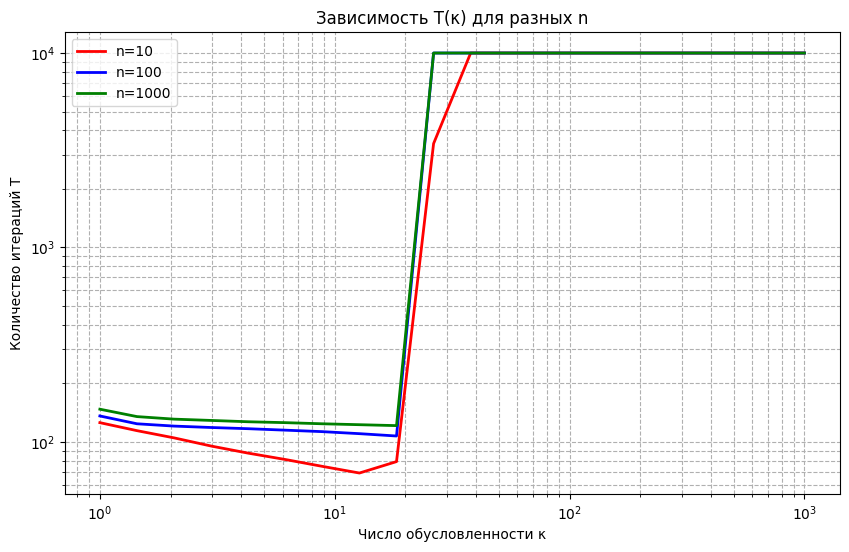

In [5]:
import numpy as np
import scipy.sparse
import matplotlib.pyplot as plt
from optimization import gradient_descent
from oracles import QuadraticOracle

def generate_quadratic_problem(n, kappa, seed=None):
    """
    Генерирует квадратичную задачу с заданной обусловленностью κ и размерностью n.
    В качестве матрицы A используется диагональная матрица с элементами в диапазоне [1, κ].
    """
    if seed is not None:
        np.random.seed(seed)  # Установка семени для воспроизводимости
    # Генерируем вектор диагональных элементов равномерно в диапазоне [1, κ]
    a = np.random.uniform(1, kappa, size=n)
    # Создаем разреженную диагональную матрицу A
    A = scipy.sparse.diags(a, format='dia')
    # Генерируем вектор свободных членов b с нормальным распределением
    b = np.random.randn(n)
    return QuadraticOracle(A, b)  # Возвращаем оракул для квадратичной функции

def run_single_trial(oracle, x0, tol=1e-5):
    """
    Запускает градиентный спуск для заданного оракула и начальной точки.
    Возвращает количество итераций, сделанных до сходимости.
    """
    _, _, hist = gradient_descent(
        oracle, x0,
        tolerance=tol,
        max_iter=10000,
        line_search_options={'method':'Constant', 'c':0.1},  # Параметры поиска шага
        trace=True,  # Включает запись истории итераций
        display=False  # Отключает вывод деталей во время работы
    )
    # Возвращаем число итераций: длина истории функции или максимум
    return len(hist['func']) if hist and 'func' in hist else 10000

# Основной эксперимент
n_values = [10, 100, 1000]  # Различные размеры задач
kappa_values = np.logspace(0, 3, 20)  # κ в диапазоне от 1 до 1000 (логарифмическое распределение)

results = {}  # Структура для хранения результатов: results[n][trial] = [список T(κ)]
colors = ['r', 'b', 'g', 'm', 'c']  # Цвета для линий графика для разных n

plt.figure(figsize=(10, 6))
for idx, n in enumerate(n_values):
    results[n] = []
    for trial_num in range(3):  # Повторяем 3 раза для усреднения
        T_kappa = []  # Список для хранения числа итераций при разных κ в текущем повторении
        for kappa in kappa_values:
            # Генерируем задачу с текущими n и κ
            oracle = generate_quadratic_problem(n, kappa, seed=trial_num)
            # Начальная точка — случайный вектор
            x0 = np.random.randn(n)
            # Запускаем градиентный спуск и получаем число итераций
            T = run_single_trial(oracle, x0)
            T_kappa.append(T)
        results[n].append(T_kappa)
    # Построение среднего значения T(κ) для каждого n
    T_avg = np.mean(results[n], axis=0)
    plt.plot(kappa_values, T_avg, color=colors[idx], label=f'n={n}', linewidth=2)

# Настройка логарифмических масштабов по осям
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Число обусловленности κ')
plt.ylabel('Количество итераций T')
plt.title('Зависимость T(κ) для разных n')
plt.legend()
plt.grid(True, which='both', ls='--')  # Сетка для обеих шкал
plt.show()

Этот эксперимент показывает, как ухудшение условия матрицы (увеличение обусловленности κ\kappaκ) негативно сказывается на скорости сходимости градиентного спуска при решении квадратичных задач.

Для всех трех значений n (10, 100 и 1000) графики показывают похожую тенденцию: при малых κ число итераций снижается или стабилизируется, а при увеличении k резко возрастает.
Есть характерный "пик" или "переход", где количество итераций резко возрастает, после чего становится практически постоянным или очень большим.

При маленьких κ (около 1-10) число итераций относительно невысокое и примерно одинаковое для всех n.
Это объясняется тем, что при низкой обусловленности градиентный спуск сходится быстрее, так как функции менее "извилистые" и с меньшей численной чувствительностью.

При увеличении κ (особенно в диапазоне 10-1000) количество итераций резко возрастает.
Этот рост характерен для алгоритмов оптимизации на плохо обусловленных задачах: увеличение κ ухудшает условие задачи, что замедляет сходимость градиентных методов.
В области высокой обусловленности, число итераций растет очень быстро (приблизительно экспоненциально), что видно по крутой кривой

После определенного значения κ (около 100-200), число итераций стабилизируется или достигает очень высокого уровня (около 10^4).
Это показывает, что градиентный спуск уже неэффективен для очень плохо обусловленных задач и достигает лимита по скорости.

Чем больше размер задачи n, тем выше среднее число итераций для одинакового κ.
Для n=1000, график показывает более высокие значения T(κ), особенно в области высокой обусловленности.
В целом, увеличение размера задачи увеличивает количество итераций, что ожидаемо, так как размерность влияет на сложность задачи.

Логарифмическое масштабирование по осям идеально подходит для отображения широкого диапазона κ и T.
Это позволяет видеть экспоненциальный рост и сравнивать разные случаи.